# Customer Interactions

I am using commercial datasets, therefore, I will not be able to share them publicly!

------------

### Rows and Features
Each line in the dataset contains a series of 15 previous interactions and a target interaction column:
* When clients are interacting with our system, typically they are on happy path but occasionally they deviate from it which may result in negative experience while impacting customer interactions, I would like to predict those negative experiences at any given time by checking past 15 customer interaction data points over 30 days, even if there is more, the set is restricted to most recent 15 actions.

The data source is customer interactions, each code represent an event, true nature of interctions is not described, though:
* I gathered such data and defined the data model what would need to look for, represented by columns as below, all features are numeric, as explained interactions are transformed into numerical codes.
* id is a unique identifier per row which bundles interactions together within the row
* prev_action_15 
through
* prev_action_1 columns
    * they contain previous interaction codes, from oldest to newest action code: prev_action_15 being oldest and prev_action_1 being most recent in the data model representation
    * If there are not enough data points in client interaction history, 0 will be placed in these previous action columns. Please note, semantically, zeros will start appearing from prev_action_15 (from oldest to newest). 0 cannot be on prev_action_1 which means no entry over 30 days for this client!
* action is the target column
* Sample data below:

|id	|prev_action_15	|prev_action_14	|prev_action_13	|prev_action_12	|prev_action_11	|prev_action_10	|prev_action_9	|prev_action_8	|prev_action_7	|prev_action_6	|prev_action_5	|prev_action_4	|prev_action_3	|prev_action_2	|prev_action_1	|action|
|---|---------------|---------------|---------------|---------------|---------------|---------------|-------------	|--------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|------|
|19059237|	104|	158|	131|	72|	179|	75|	75|	73|	180|	180|	179|	180|	75|	55|	75|	55|
|73879930|	0|	0|	0|	75|	77|	162|	75|	75|	75|	75|	75|	111|	111|	55|	75|	55|

Note to the second line entry, there are not enough entries, so, 3 0s in those columns. The data columns are filled with 0 if interaction is missing.


For the capstone project, I am using series of customer interactions to predict a couple target actions:
- 142 and
- 55

to be proactive about those negative outcomes. Data is customer interaction set, they are generated when customer is actively interacting with the system, so, there are no regular intervals. It is cleaned from the data source and are all masked and generalized to avoid revealing any sensitive information. True identity, action numbers are all masked and datetime are removed, they are not linked to any actual data whatsoever.

### Target Variable
Target variable `action` should be transformed to 0/1 for model execution:
 - 0 means it is a positive experience, no concern!
 - 1 means negative experience, it is a concern, may need to be proactive about this customer! 

### Models
The techniques to use in analysis
* This first phase focus is binary classification, specifically the techniques I would like to utilize are
 `k-Nearest Neighbors`,
 `Logistic Regression` and
 `Decision Tree`.

The expected results
* The expected result is predicting action column in my dataset and also discover interaction patterns. In the initial phase, my approach will be two models to predict action code = `55` and `142` respectively. Optionally, the next phase will be a multi-class model to predict multi-class action code = `55` and/or `142` with probability as multinomial model but this is not a deal breaker.

Why this question is important
* This is a preliminary work in parallel to an ongoing work, I would like to apply the techniques I learnt, see if it helps in anyway to identify those patterns in the dataset, or any improvement point I could bring up comparing my results with the existing work. A working classification model is highly desired here to compare its performance with the existing outcome.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, \
                            accuracy_score, recall_score, precision_score, precision_recall_curve
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config

In [31]:
# figure or diagram to visualize pipeline
set_config(display='diagram')

# Exploratory Data Analysis
Data in the file is already cleaned up, no further procesing required.
Target variable `action` needs to be set to 0/1 depending on the dataset is used below.

In [32]:
# Read actions from excel sheet
xlsx = pd.ExcelFile('data/interactions_08052022.xlsx')
# Tab names for 2 set of samples 55 and 142
# 142
actions1 = pd.read_excel(xlsx, 'Sample H')
# 55
actions2 = pd.read_excel(xlsx, 'Sample A')

In [33]:
# start time
tstart = datetime.now()
print(tstart)

2022-09-24 07:47:27.717025


# Dataset #1 for Interaction 142

In [34]:
actions1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4048 entries, 0 to 4047
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              4048 non-null   int64
 1   prev_action_15  4048 non-null   int64
 2   prev_action_14  4048 non-null   int64
 3   prev_action_13  4048 non-null   int64
 4   prev_action_12  4048 non-null   int64
 5   prev_action_11  4048 non-null   int64
 6   prev_action_10  4048 non-null   int64
 7   prev_action_9   4048 non-null   int64
 8   prev_action_8   4048 non-null   int64
 9   prev_action_7   4048 non-null   int64
 10  prev_action_6   4048 non-null   int64
 11  prev_action_5   4048 non-null   int64
 12  prev_action_4   4048 non-null   int64
 13  prev_action_3   4048 non-null   int64
 14  prev_action_2   4048 non-null   int64
 15  prev_action_1   4048 non-null   int64
 16  action          4048 non-null   int64
dtypes: int64(17)
memory usage: 537.8 KB


In [35]:
# Replace all None with 0 in the dataset if any
#actions.replace('None', 0, inplace = True)

In [36]:
pd.options.display.max_columns = None

In [37]:
actions1

,id,prev_action_15,prev_action_14,prev_action_13,prev_action_12,prev_action_11,prev_action_10,prev_action_9,prev_action_8,prev_action_7,prev_action_6,prev_action_5,prev_action_4,prev_action_3,prev_action_2,prev_action_1,action
0,12711414,25,25,25,25,25,25,25,25,25,25,179,25,180,143,142,142
1,20635155,185,185,142,185,185,142,185,185,185,185,142,185,185,185,185,142
2,44789016,179,180,48,179,179,180,180,179,180,179,179,180,179,180,180,142
3,75610491,1,4,4,4,5,5,4,4,75,75,179,180,142,142,142,142
4,70030494,179,142,180,180,75,179,180,143,75,75,179,180,179,180,75,142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,84778540,0,0,0,0,0,0,0,0,0,0,76,76,76,76,76,76
4044,31998299,0,0,0,0,0,0,0,46,48,46,46,179,180,46,179,180
4045,79580262,0,0,0,0,0,0,0,75,158,48,179,180,46,46,179,180
4046,91488534,179,180,46,76,75,158,46,179,180,75,158,75,48,179,180,46


In [38]:
actions1.describe()

,id,prev_action_15,prev_action_14,prev_action_13,prev_action_12,prev_action_11,prev_action_10,prev_action_9,prev_action_8,prev_action_7,prev_action_6,prev_action_5,prev_action_4,prev_action_3,prev_action_2,prev_action_1,action
count,4.048000e+03,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000
mean,5.034346e+07,78.953557,81.502717,84.197134,86.343132,89.644516,92.356472,94.340662,97.752470,102.304842,103.166008,106.316206,113.518775,112.826087,112.386364,132.516798,130.677619
std,2.892457e+07,74.652261,74.868084,74.256514,73.748875,73.659290,73.240317,72.071964,71.637751,71.294376,69.462731,67.917025,66.641673,63.214168,61.339991,52.447121,41.474182
min,2.054000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,2.510344e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.000000,46.000000,46.000000,75.000000,75.000000,46.000000,76.000000,76.000000
50%,5.074918e+07,75.000000,75.000000,76.000000,77.000000,80.000000,110.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
75%,7.540206e+07,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,142.000000
max,9.999633e+07,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,230.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000


In [39]:
# %%time
# # histograms
# actions1.hist(figsize = (16, 16))
# plt.show()

# Dataset #2 for Interaction 55

In [40]:
actions2

,id,prev_action_15,prev_action_14,prev_action_13,prev_action_12,prev_action_11,prev_action_10,prev_action_9,prev_action_8,prev_action_7,prev_action_6,prev_action_5,prev_action_4,prev_action_3,prev_action_2,prev_action_1,action
0,1873817,68,179,73,180,68,179,68,68,180,75,179,180,179,180,75,55
1,6742635,72,75,179,180,75,75,75,75,75,75,179,180,76,76,75,55
2,53659561,105,75,75,75,105,105,46,183,183,179,180,46,183,183,179,180
3,86755049,104,46,105,104,46,105,104,111,111,46,56,56,56,105,104,55
4,45702739,105,104,111,111,55,105,104,111,111,55,105,104,55,105,104,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,56599632,184,183,179,184,180,75,75,75,75,46,183,184,183,179,184,180
14996,64127369,184,180,158,159,75,159,158,75,75,46,183,184,183,179,184,180
14997,54735655,184,183,179,184,180,46,183,183,179,184,180,179,180,77,75,55
14998,81904597,184,183,179,180,75,48,46,179,180,179,180,75,75,46,179,180


In [41]:
actions2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              15000 non-null  int64
 1   prev_action_15  15000 non-null  int64
 2   prev_action_14  15000 non-null  int64
 3   prev_action_13  15000 non-null  int64
 4   prev_action_12  15000 non-null  int64
 5   prev_action_11  15000 non-null  int64
 6   prev_action_10  15000 non-null  int64
 7   prev_action_9   15000 non-null  int64
 8   prev_action_8   15000 non-null  int64
 9   prev_action_7   15000 non-null  int64
 10  prev_action_6   15000 non-null  int64
 11  prev_action_5   15000 non-null  int64
 12  prev_action_4   15000 non-null  int64
 13  prev_action_3   15000 non-null  int64
 14  prev_action_2   15000 non-null  int64
 15  prev_action_1   15000 non-null  int64
 16  action          15000 non-null  int64
dtypes: int64(17)
memory usage: 1.9 MB


In [42]:
actions2.describe()

,id,prev_action_15,prev_action_14,prev_action_13,prev_action_12,prev_action_11,prev_action_10,prev_action_9,prev_action_8,prev_action_7,prev_action_6,prev_action_5,prev_action_4,prev_action_3,prev_action_2,prev_action_1,action
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,5.017598e+07,59.002067,60.158200,63.041200,64.838200,65.712000,69.223867,71.617400,71.868200,75.712067,77.634333,89.195933,98.256467,94.400533,96.421533,115.547533,93.516667
std,2.894509e+07,72.105794,71.911283,73.000656,73.120491,72.201368,73.157396,72.541931,71.559497,72.083380,70.571241,65.490695,65.151531,62.040644,60.599346,59.819464,55.841602
min,7.138000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.516904e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,55.000000,48.000000,46.000000,75.000000,55.000000
50%,5.024182e+07,0.000000,41.000000,46.000000,46.000000,46.000000,48.000000,55.000000,55.000000,75.000000,75.000000,76.000000,80.000000,76.000000,77.000000,104.000000,55.000000
75%,7.546675e+07,101.000000,103.000000,111.000000,158.000000,131.000000,162.000000,179.000000,159.000000,179.000000,179.000000,179.000000,179.000000,179.000000,158.000000,179.000000,180.000000
max,9.999584e+07,220.000000,229.000000,229.000000,219.000000,234.000000,229.000000,230.000000,220.000000,230.000000,230.000000,219.000000,230.000000,229.000000,230.000000,220.000000,220.000000


In [43]:
# %%time
# # histograms
# actions2.hist(figsize = (16, 16))
# plt.show()

## Data Cleanup and Transformation
No cleanup needed. However, row cleanup may be needed, for example, any account do not have more than or equal to previous 5 records history will be removed after exploring the datasets!

### Data Transformation
```
 event -> 142 to 1, rest to 0 for action1
 event -> 55 to 1, rest to 0 for action2
```

Below function `process_set` sets the dataset and prepares the target variable for model execution in this phase it is a manual selection but in the final phase, I will process these two files all at once by either multinomial model or individual models in the notebook.

In [44]:
#  event -> 142 to 1, rest to 0 if dataset is 1
#  event -> 55 to 1, rest to 0 if dataset is 2
def process_set(dataset):
    # prepare global dataset and return
    df = globals()['actions' + str(dataset)]
    # assign 0/1 for the event (by the chosen dataset) we are targeting:
    if dataset == 1:
        action = 142
    else:
        action = 55

    # Transform target column to 0/1 for yes/no
    # prepare target column as 1/0
    df.loc[df['action'] != action, 'action'] = 0
    df.loc[df['action'] == action, 'action'] = 1
    df['action'] = df['action'].astype('int64')

    return df

# Set Dataset 2 to Process

In [45]:
# Copy dataset either 1 or 2
data_set = 2
act = process_set(data_set)

In [46]:
act.describe()

,id,prev_action_15,prev_action_14,prev_action_13,prev_action_12,prev_action_11,prev_action_10,prev_action_9,prev_action_8,prev_action_7,prev_action_6,prev_action_5,prev_action_4,prev_action_3,prev_action_2,prev_action_1,action
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,5.017598e+07,59.002067,60.158200,63.041200,64.838200,65.712000,69.223867,71.617400,71.868200,75.712067,77.634333,89.195933,98.256467,94.400533,96.421533,115.547533,0.500000
std,2.894509e+07,72.105794,71.911283,73.000656,73.120491,72.201368,73.157396,72.541931,71.559497,72.083380,70.571241,65.490695,65.151531,62.040644,60.599346,59.819464,0.500017
min,7.138000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.516904e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,55.000000,48.000000,46.000000,75.000000,0.000000
50%,5.024182e+07,0.000000,41.000000,46.000000,46.000000,46.000000,48.000000,55.000000,55.000000,75.000000,75.000000,76.000000,80.000000,76.000000,77.000000,104.000000,0.500000
75%,7.546675e+07,101.000000,103.000000,111.000000,158.000000,131.000000,162.000000,179.000000,159.000000,179.000000,179.000000,179.000000,179.000000,179.000000,158.000000,179.000000,1.000000
max,9.999584e+07,220.000000,229.000000,229.000000,219.000000,234.000000,229.000000,230.000000,220.000000,230.000000,230.000000,219.000000,230.000000,229.000000,230.000000,220.000000,1.000000


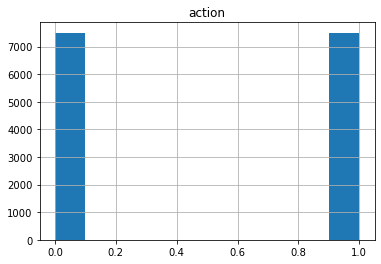

CPU times: user 99.8 ms, sys: 4.35 ms, total: 104 ms
Wall time: 107 ms


In [47]:
%%time
# make sure it is balanced!
act[['action']].hist()
plt.show()

In [48]:
act

,id,prev_action_15,prev_action_14,prev_action_13,prev_action_12,prev_action_11,prev_action_10,prev_action_9,prev_action_8,prev_action_7,prev_action_6,prev_action_5,prev_action_4,prev_action_3,prev_action_2,prev_action_1,action
0,1873817,68,179,73,180,68,179,68,68,180,75,179,180,179,180,75,1
1,6742635,72,75,179,180,75,75,75,75,75,75,179,180,76,76,75,1
2,53659561,105,75,75,75,105,105,46,183,183,179,180,46,183,183,179,0
3,86755049,104,46,105,104,46,105,104,111,111,46,56,56,56,105,104,1
4,45702739,105,104,111,111,55,105,104,111,111,55,105,104,55,105,104,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,56599632,184,183,179,184,180,75,75,75,75,46,183,184,183,179,184,0
14996,64127369,184,180,158,159,75,159,158,75,75,46,183,184,183,179,184,0
14997,54735655,184,183,179,184,180,46,183,183,179,184,180,179,180,77,75,1
14998,81904597,184,183,179,180,75,48,46,179,180,179,180,75,75,46,179,0


In [49]:
act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              15000 non-null  int64
 1   prev_action_15  15000 non-null  int64
 2   prev_action_14  15000 non-null  int64
 3   prev_action_13  15000 non-null  int64
 4   prev_action_12  15000 non-null  int64
 5   prev_action_11  15000 non-null  int64
 6   prev_action_10  15000 non-null  int64
 7   prev_action_9   15000 non-null  int64
 8   prev_action_8   15000 non-null  int64
 9   prev_action_7   15000 non-null  int64
 10  prev_action_6   15000 non-null  int64
 11  prev_action_5   15000 non-null  int64
 12  prev_action_4   15000 non-null  int64
 13  prev_action_3   15000 non-null  int64
 14  prev_action_2   15000 non-null  int64
 15  prev_action_1   15000 non-null  int64
 16  action          15000 non-null  int64
dtypes: int64(17)
memory usage: 1.9 MB


No further cleaning is needed on the dataset, ready!

In [22]:
#act.columns

Index(['id', 'prev_action_15', 'prev_action_14', 'prev_action_13',
       'prev_action_12', 'prev_action_11', 'prev_action_10', 'prev_action_9',
       'prev_action_8', 'prev_action_7', 'prev_action_6', 'prev_action_5',
       'prev_action_4', 'prev_action_3', 'prev_action_2', 'prev_action_1',
       'action'],
      dtype='object')

# Split Dataset for Train and Test

In [50]:
# separate independent variable - features - from target and split training and test datasets
X, y = act.drop(['id', 'action'], axis = 1), act['action']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 93, stratify = y)

In [51]:
# make sure target is balanced!
act['action'].value_counts(), y_test.value_counts()

(1    7500
 0    7500
 Name: action, dtype: int64,
 1    1875
 0    1875
 Name: action, dtype: int64)

Both datasets are balanced, they are ready to use. Target variable `action` are transformed to 0/1 by `process_set` above already!

# Define Reusable Functions

In [52]:
# Precision vs Recall Chart
def precision_recall_chart(y_set, preds):
    precision, recall, boundaries = precision_recall_curve(y_true = y_set,
                                                           probas_pred=preds, pos_label=1)
    # 
    print(boundaries[:5])
    plt.subplots(figsize=(10,8))
    plt.plot(precision, recall, '--o')
    plt.xticks(np.arange(0, 1.2, .1))
    plt.grid(True)
    plt.ylabel('Recall')
    plt.xlabel('Precision')
    plt.title('Precision vs Recall')
    plt.show()

In [53]:
# confusion_matrix & AUC plots
def confusion_matrix_auc(model, X_set, y_set, preds):
    fig, ax = plt.subplots(1, 2, figsize = (14, 7))
    ConfusionMatrixDisplay.from_predictions(y_set, preds, values_format='d',
                                            display_labels=['No', 'Yes'], ax=ax[0])
    ax[0].set_title(f'Confusion Matrix: {sum(~preds & y_set) + sum(preds & ~y_set)}')
    ax[0].grid(False)
    RocCurveDisplay.from_estimator(model, X_set, y_set, pos_label=1, ax = ax[1])
    ax[1].plot(np.array([0, 1]), np.array([0, 1]))
    ax[1].grid(False)
    plt.show()

In [54]:
# Print scores
def print_results(model):
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)

    # Print results
    print(f'Accuracy : {accuracy: .2f}\nPrecision: {precision: .2f}\nRecall   : {recall: .2f}')

In [55]:
# Plot Low, Default, High matrices in a row
def plot_confusion_matrices(model):
    model_preds = model.predict(X_test)
    model_proba = model.predict_proba(X_test)

    # adjust decision boundary
    lo_preds = np.where(model_proba[:, 1] > .4, 1, 0)
    hi_preds = np.where(model_proba[:, 1] > .6, 1, 0)
    # print
    print(sum(~lo_preds & y_test) + sum(lo_preds & ~y_test), 
          sum(~model_preds & y_test) + sum(model_preds & ~y_test),
          sum(~hi_preds & y_test) + sum(hi_preds & ~y_test))

    # plot confusion matrices
    fig, ax = plt.subplots(1, 3, figsize = (16, 3))
    ConfusionMatrixDisplay.from_predictions(y_test, lo_preds, display_labels = ['No', 'Yes'], ax = ax[0])
    ConfusionMatrixDisplay.from_predictions(y_test, model_preds, display_labels = ['No', 'Yes'], ax = ax[1])
    ConfusionMatrixDisplay.from_predictions(y_test, hi_preds, display_labels = ['No', 'Yes'], ax = ax[2])
    ax[0].grid(False)
    ax[1].grid(False)
    ax[2].grid(False)
    ax[0].set_title(f'Low Threshold at 0.4\nConfusion Matrix: {sum(~lo_preds & y_test) + sum(lo_preds & ~y_test)}')
    ax[1].set_title(f'Default Threshold at 0.5\nConfusion Matrix: {sum(~model_preds & y_test) + sum(model_preds & ~y_test)}')
    ax[2].set_title(f'High Threshold at 0.6\nConfusion Matrix: {sum(~hi_preds & y_test) + sum(hi_preds & ~y_test)}')

In [56]:
#Accuracy, Precision and Recall vs. Decision Thresholds
def build_and_plot_thresholds(y_set, probas):
    # adjust decision boundary
    thresholds = np.arange(0, 1, .1)
    # auc decision boundary
    threshold_df = pd.DataFrame(
        {'threshold':thresholds,
         #'accuracy' :[accuracy_score(y_set, np.where(probas[:, 1] >= t, 1, 0) ) for t in thresholds],
         'precision':[precision_score(y_set, np.where(probas[:, 1] >= t, 1, 0),
                                      pos_label=1, zero_division=0, average='weighted') for t in thresholds],
         'recall'   :[recall_score(y_set, np.where(probas[:, 1] >= t, 1, 0),
                                   pos_label=1, zero_division=0, average='weighted') for t in thresholds]
        })
    # print thereshold table
    print(threshold_df)

    # plot Accuracy, Precision and Recall vs. Decision Thresholds
    plt.subplots(figsize=(10,8))
    #plt.plot(threshold_df['threshold'], threshold_df['accuracy'], '--o', label = 'accuracy')
    plt.plot(threshold_df['threshold'], threshold_df['precision'], '--o', label = 'precision')
    plt.plot(threshold_df['threshold'], threshold_df['recall'], '--o', label = 'recall')
    #plt.axvline(x=0.45, color="black", label = 'intersection')
    plt.xticks(thresholds)
    plt.xlabel('Threshold')
    plt.ylabel('Scores')
    plt.title('Precision and Recall vs. Decision Thresholds')
    plt.legend()
    plt.grid(True)

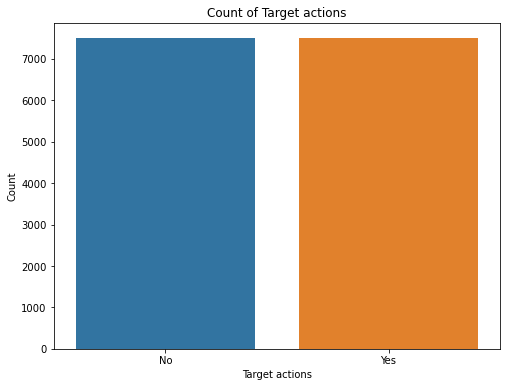

In [57]:
# check target data distribution
plt.subplots(figsize=(8,6))
splot = sns.countplot(data=act, x = 'action')
splot.set_xticklabels(['No', 'Yes'])
plt.xlabel('Target actions')
plt.ylabel('Count')
plt.title('Count of Target actions')
plt.show()

In [58]:
# entire dataset
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: action, dtype: float64

In [59]:
# train set
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: action, dtype: float64

In [60]:
# test set
y_test.value_counts(normalize=True)

1    0.5
0    0.5
Name: action, dtype: float64

In [61]:
##y_train.shape, y_test.shape

# Random Forest Classifier
Execute RandomForestClassifierDecisionTreeClassifier model with default hyperparemeters

In [62]:
# since there is no aplhanumeric columns, we can just scale and classify data, no transformation needed
# Note: n_neighbors=5 and weights='uniform' by default!
action_dtc = RandomForestClassifier().fit(X_train, y_train)
action_preds = action_dtc.predict(X_test)
action_proba = action_dtc.predict_proba(X_test)
action_dtc

RandomForestClassifier()

   threshold  precision    recall
0        0.0   0.250000  0.500000
1        0.1   0.869871  0.833867
2        0.2   0.904480  0.894400
3        0.3   0.915468  0.911467
4        0.4   0.922999  0.921867
5        0.5   0.921648  0.921600
6        0.6   0.915598  0.915200
7        0.7   0.900300  0.897600
8        0.8   0.872009  0.840000
9        0.9   0.854368  0.800800


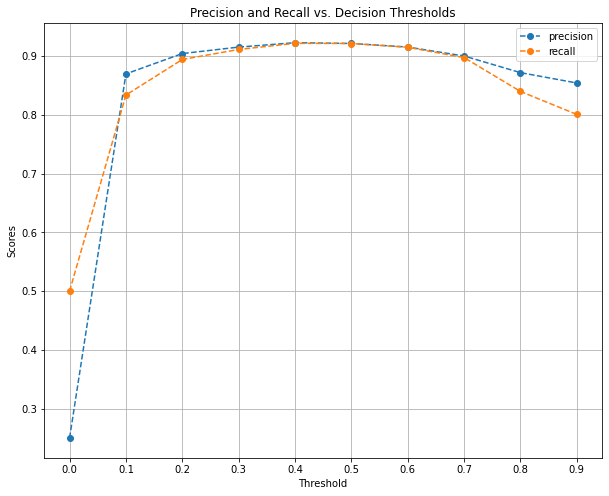

In [63]:
# plot Precision and Recall vs. Decision Thresholds
build_and_plot_thresholds(y_test, action_proba)

[0.         0.00015385 0.006      0.00777115 0.01      ]


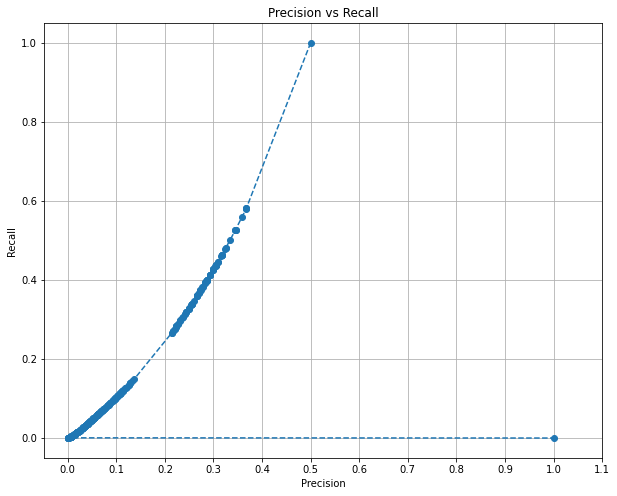

In [64]:
# Precision vs Recall Chart
precision_recall_chart(y_test, action_proba[:, 0])

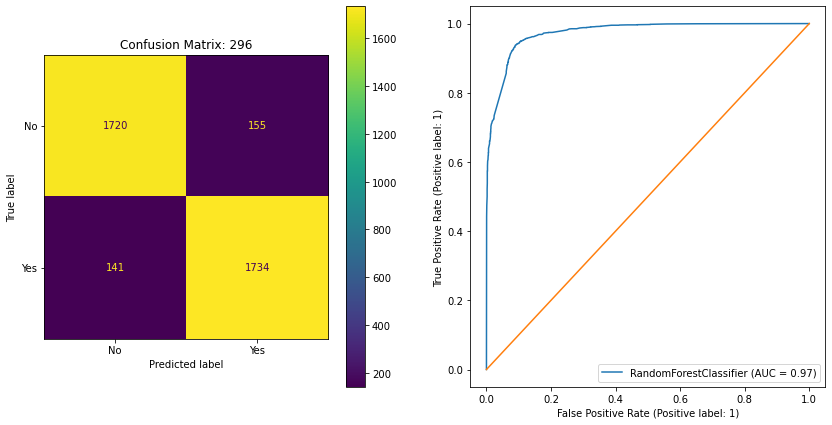

In [65]:
# plot confusion matrix and AUC
confusion_matrix_auc(action_dtc, X_test, y_test, action_preds)

In [66]:
# KNN results
print_results(action_dtc)

Accuracy :  0.92
Precision:  0.92
Recall   :  0.92


In [67]:
#action_preds
# action_preds.ravel()

In [68]:
# # adjust decision boundary
# low_preds = np.where(action_proba[:, 1] > .4, 1, 0)
# high_preds = np.where(action_proba[:, 1] > .6, 1, 0)
# print(sum((~low_preds) & y_test), sum(~action_preds & y_test), sum(~high_preds & y_test))

294 296 318


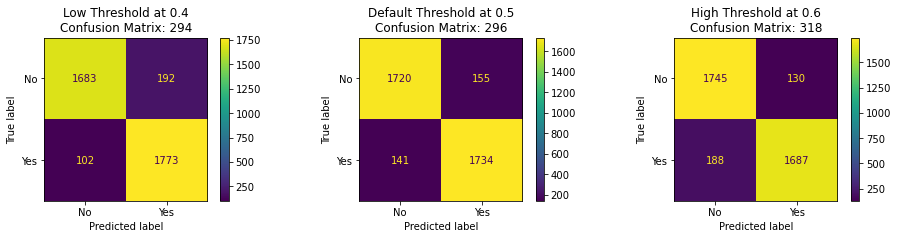

In [69]:
# plot confusion matrices
plot_confusion_matrices(action_dtc)

In [70]:
# Target actions deviation
# y_test[y_test!=action_preds], action_preds[y_test!=action_preds], action_proba[y_test!=action_preds]

In [71]:
#X_test dataframe
X_test[y_test!=action_preds]

,prev_action_15,prev_action_14,prev_action_13,prev_action_12,prev_action_11,prev_action_10,prev_action_9,prev_action_8,prev_action_7,prev_action_6,prev_action_5,prev_action_4,prev_action_3,prev_action_2,prev_action_1
8338,35,75,75,75,75,159,158,35,35,35,179,180,179,180,75
12367,179,180,180,180,75,159,75,46,183,183,183,183,183,179,180
2722,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77
11424,77,162,75,75,75,179,180,75,179,180,179,180,46,179,180
11507,77,75,75,75,75,75,75,75,76,76,76,75,75,75,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11833,179,184,180,46,183,183,183,184,184,183,179,184,180,179,180
11604,77,75,75,75,46,46,179,179,180,180,179,180,75,77,75
10559,75,75,75,75,75,75,179,180,75,75,75,75,75,75,75
3191,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
#action_proba[y_test!=action_preds]

In [73]:
#transformed_features = lgr_pipe.named_steps['transformer'].get_feature_names_out(X_test.columns)
#transformed_features = [str.split(x, sep = '__')[1] for x in transformed_features]
#-----
#feature_names = action_pipeline.named_steps['scale'].get_feature_names_out(X_test.columns)
feature_names = X.columns


In [74]:
action_dtc.predict_proba(X_test)[:,0]

array([0.27, 1.  , 0.95, ..., 0.55, 0.01, 1.  ])

In [75]:
#action_pipeline[:-1].get_feature_names_out()

In [76]:
#action_pipeline['scale'].get_feature_names_out()

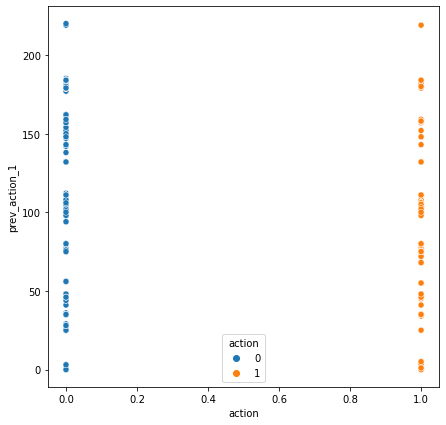

In [77]:
# plot all
# current interaction versus previous interaction
plt.subplots(figsize=(7,7))
sns.scatterplot(data = act, x = 'action', y = 'prev_action_1', hue = y)
plt.show()

# Tune the Model

accuracy: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'random_state': 93}  score: 0.920888888888889
Accuracy :  0.92
Precision:  0.92
Recall   :  0.94


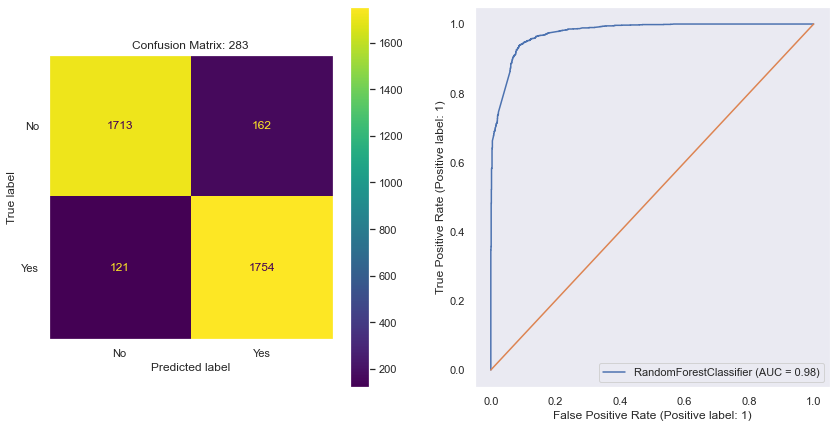

precision: {'criterion': 'entropy', 'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 93}  score: 0.9070694520730613
Accuracy :  0.92
Precision:  0.92
Recall   :  0.93


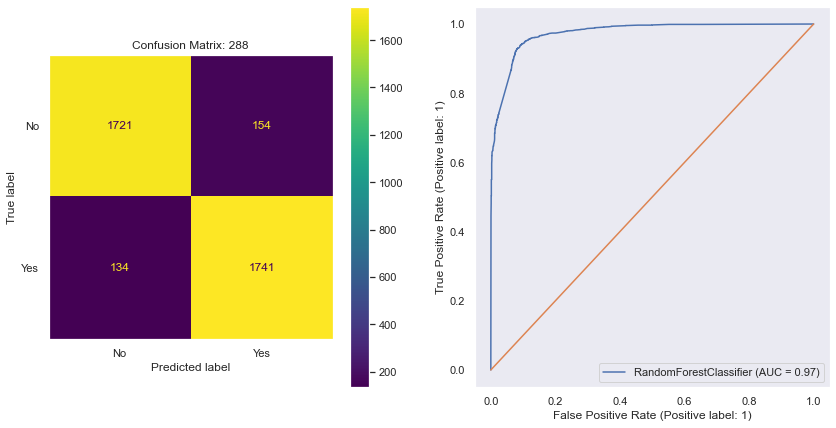

recall: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': 93}  score: 0.9427555555555556
Accuracy :  0.92
Precision:  0.90
Recall   :  0.94


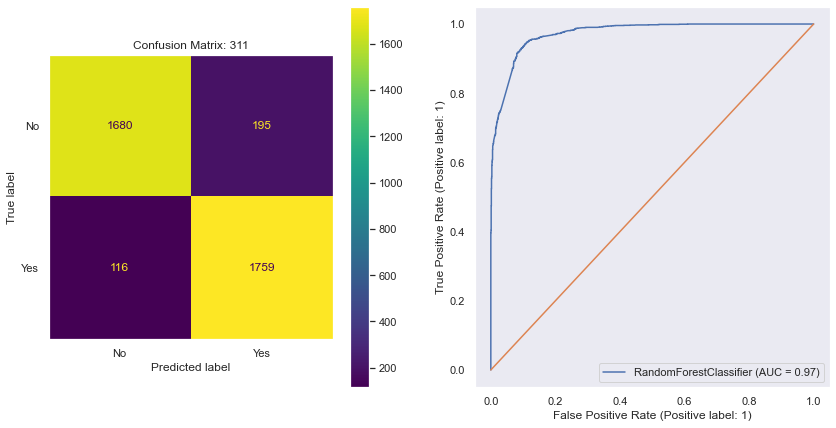

roc_auc: {'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 5, 'random_state': 93}  score: 0.9750622814814814
Accuracy :  0.92
Precision:  0.91
Recall   :  0.93


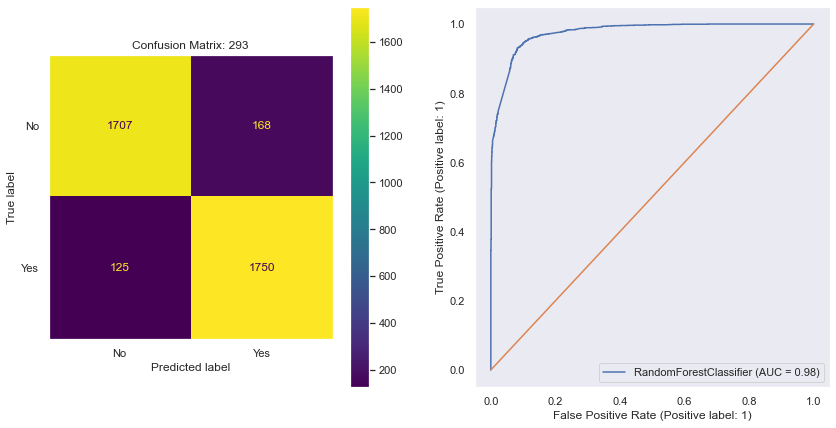

CPU times: user 1h 24min 16s, sys: 26.8 s, total: 1h 24min 43s
Wall time: 1h 24min 52s


In [50]:
%%time
params = {'max_depth': range(1, 25, 1), 'criterion':['gini', 'entropy'], 'min_samples_split':[2,3,4,5],
          'min_samples_leaf':[1,2,3], 'random_state': [93]}
for scorer in ['accuracy', 'precision', 'recall', 'roc_auc']:
    dtc_grid = GridSearchCV(action_dtc, param_grid = params, scoring=scorer)
    dtc_grid.fit(X_train, y_train)
    best_k = dtc_grid.best_params_
    print(scorer + ':', best_k, ' score:', dtc_grid.best_score_)
    # KNN results
    print_results(dtc_grid.best_estimator_)
    # plot confusion matrix and AUC
    confusion_matrix_auc( dtc_grid.best_estimator_, X_test, y_test, dtc_grid.best_estimator_.predict(X_test) )

# Best Model
GridSearchCV came out with `accuracy: {'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 3, 'random_state': 93}` on the first dataset and `accuracy: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'random_state': 93}` on the second dataset which has the lowest misclassifcation ratio of all. However, the hyperparameters on the second dataset caused more `false positives`. Running a further analysis by those parameters below.

In [78]:
# Go with dataset #1 hyperparameter findings
dtc_model = RandomForestClassifier(criterion = 'entropy', max_depth = 20, min_samples_leaf = 2,
                                   min_samples_split = 5, random_state = 93).fit(X_train, y_train)
dtc_preds = dtc_model.predict(X_test)
dtc_proba = dtc_model.predict_proba(X_test)
dtc_model

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=2,
                       min_samples_split=5, random_state=93)

300 283 308


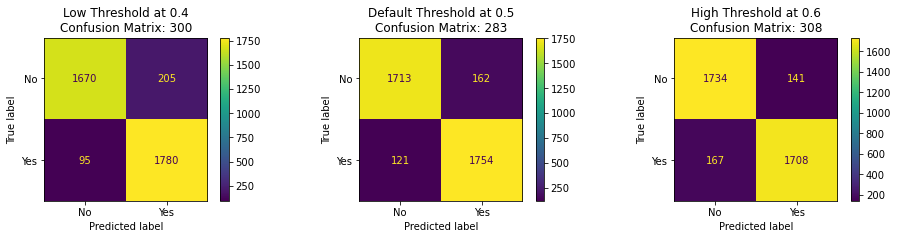

In [79]:
# plot confusion matrices
plot_confusion_matrices(dtc_model)

   threshold  precision    recall
0        0.0   0.250000  0.500000
1        0.1   0.865822  0.823467
2        0.2   0.898016  0.882933
3        0.3   0.915441  0.910667
4        0.4   0.921451  0.920000
5        0.5   0.924736  0.924533
6        0.6   0.917947  0.917867
7        0.7   0.905192  0.902933
8        0.8   0.872651  0.838933
9        0.9   0.851183  0.793333


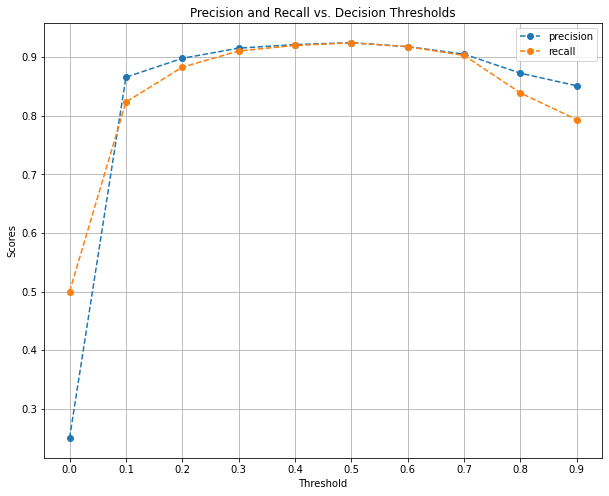

In [80]:
# plot Precision and Recall vs. Decision Thresholds
build_and_plot_thresholds(y_test, dtc_proba)

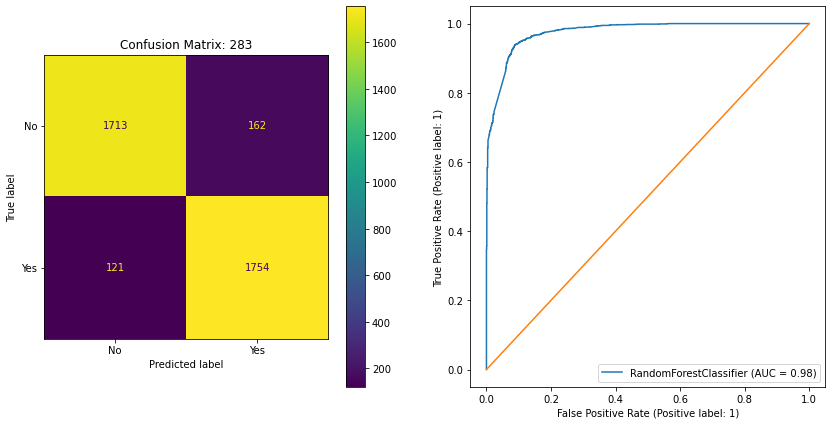

In [81]:
# High Preds
th_preds = np.where(dtc_proba[:, 1] > .5, 1, 0)
# plot confusion matrix and AUC
confusion_matrix_auc(dtc_model, X_test, y_test, th_preds)

In [82]:
print_results(dtc_model)

Accuracy :  0.92
Precision:  0.92
Recall   :  0.94


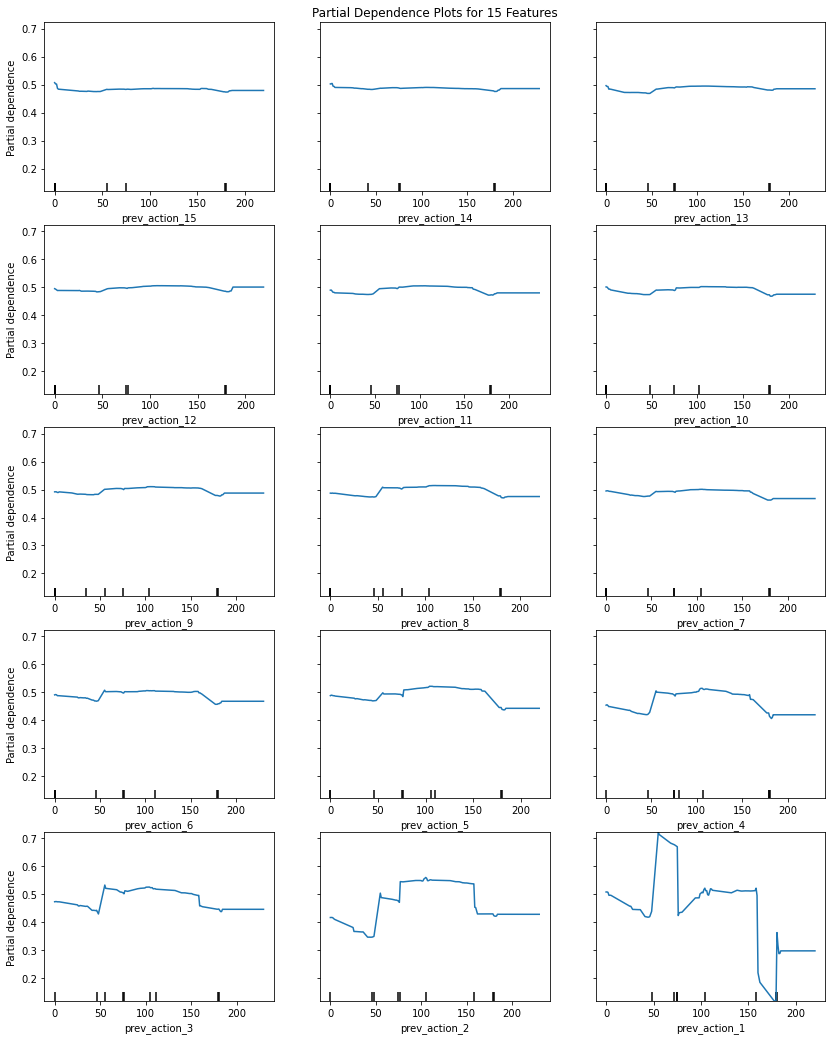

CPU times: user 1min 56s, sys: 216 ms, total: 1min 56s
Wall time: 1min 56s


In [83]:
%%time
# Partial Dependence Plots
fig, ax = plt.subplots(figsize = (14, 18))
PartialDependenceDisplay.from_estimator(dtc_model, X,
                                        features = X.columns, ax = ax)
ax.set_title(f'Partial Dependence Plots for {len(X.columns)} Features')
plt.savefig('images/dtc_partial_dependence'+str(data_set), dpi=300)
plt.show()

# Set Dataset 1 to Process

In [84]:
# Copy dataset either 1 or 2
data_set = 1
act1 = process_set(data_set)

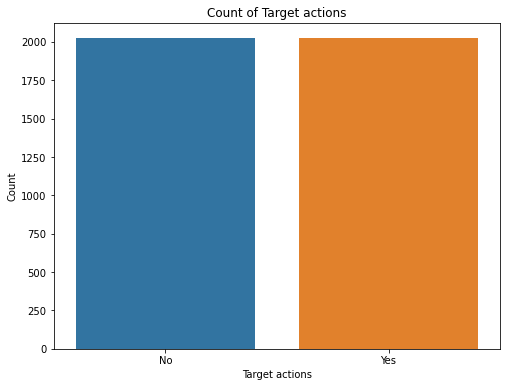

In [85]:
# check target data distribution
plt.subplots(figsize=(8,6))
splot = sns.countplot(data=act1, x = 'action')
splot.set_xticklabels(['No', 'Yes'])
plt.xlabel('Target actions')
plt.ylabel('Count')
plt.title('Count of Target actions')
plt.show()

# Split Dataset for Train and Test

In [86]:
# separate independent variable - features - from target and split training and test datasets
X, y = act1.drop(['id', 'action'], axis = 1), act1['action']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 93, stratify = y)

In [87]:
# train set
y_train.value_counts()

0    1518
1    1518
Name: action, dtype: int64

In [88]:
# test set
y_test.value_counts()

0    506
1    506
Name: action, dtype: int64

# Model for Dataset #1

In [89]:
# Go with dataset #1 hyperparameter findings
dtc_model = RandomForestClassifier(criterion = 'entropy', max_depth = 20, min_samples_leaf = 2,
                                   min_samples_split = 5, random_state = 93).fit(X_train, y_train)
dtc_preds = dtc_model.predict(X_test)
dtc_proba = dtc_model.predict_proba(X_test)
dtc_model

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=2,
                       min_samples_split=5, random_state=93)

77 81 92


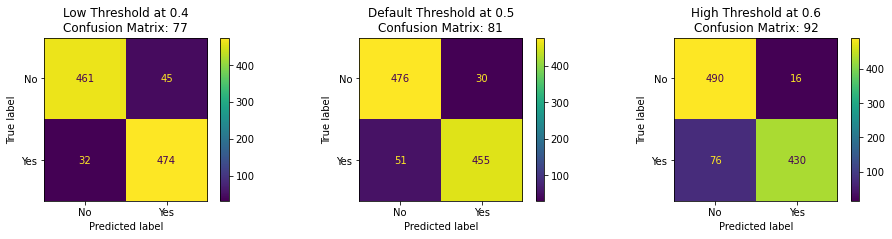

In [90]:
# plot confusion matrices
plot_confusion_matrices(dtc_model)

   threshold  precision    recall
0        0.0   0.250000  0.500000
1        0.1   0.862741  0.825099
2        0.2   0.893522  0.878458
3        0.3   0.910532  0.905138
4        0.4   0.924193  0.923913
5        0.5   0.920685  0.919960
6        0.6   0.914925  0.909091
7        0.7   0.909489  0.896245
8        0.8   0.887439  0.860672
9        0.9   0.862464  0.810277


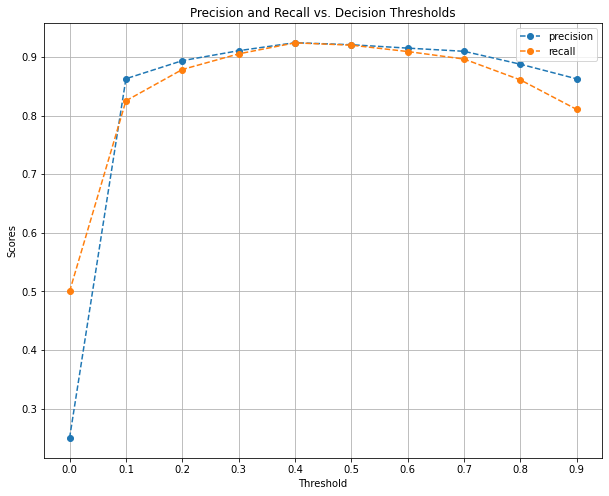

In [91]:
# plot Precision and Recall vs. Decision Thresholds
build_and_plot_thresholds(y_test, dtc_proba)

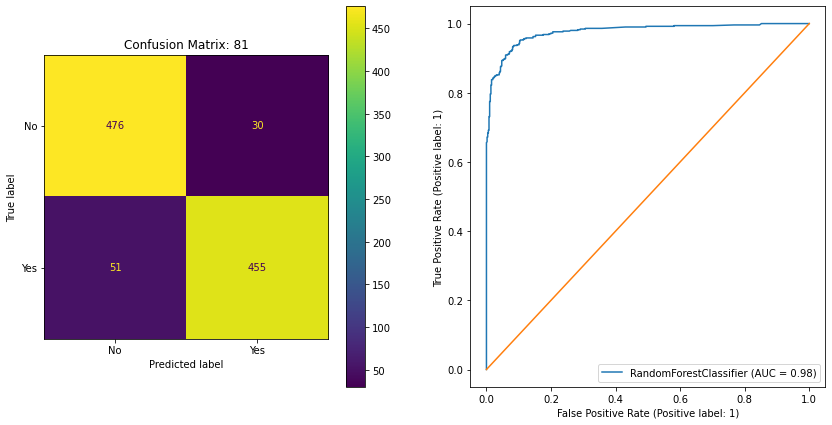

In [92]:
# High Preds
th_preds = np.where(dtc_proba[:, 1] > .5, 1, 0)
# plot confusion matrix and AUC
confusion_matrix_auc(dtc_model, X_test, y_test, th_preds)

In [93]:
print_results(dtc_model)

Accuracy :  0.92
Precision:  0.94
Recall   :  0.90


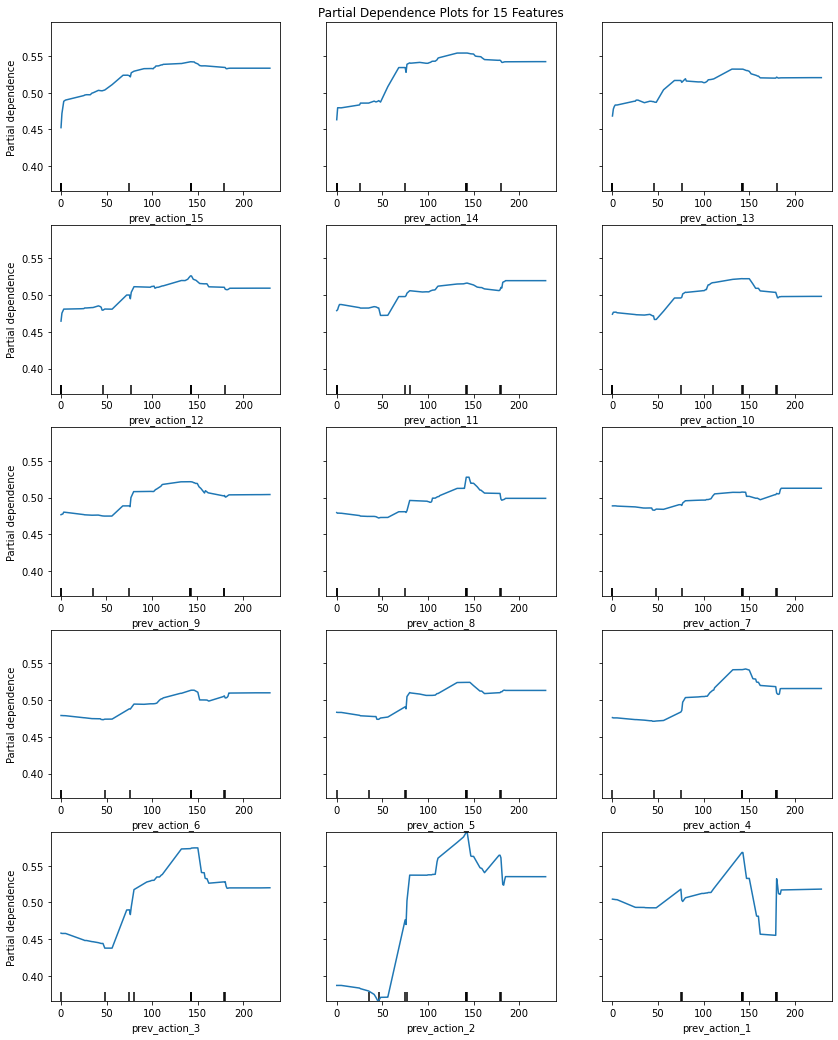

CPU times: user 27.3 s, sys: 713 ms, total: 28 s
Wall time: 28.2 s


In [94]:
%%time
# Partial Dependence Plots
fig, ax = plt.subplots(figsize = (14, 18))
PartialDependenceDisplay.from_estimator(dtc_model, X,
                                        features = X.columns, ax = ax)
ax.set_title(f'Partial Dependence Plots for {len(X.columns)} Features')
plt.savefig('images/dtc_partial_dependence'+str(data_set), dpi=300)
plt.show()

## Decision Boundary (Threshold) Adjustment
Comparing the default rate and the adjusted rates at the 0.4 and 0.6 threshold values show no improvement in misclassification rate on the second dataset. However, on the first dataset the optimum hyperparameters are giving best `false positive` misclassification which at 0.4 threshold value, although, the better outcome still negligible.

For both datasets, 0.5 thershold value helps lowering `false positive`, for this exercise a lower `false positive` is more desirable because any negative experience (true positive) may require an interaction with customer so we should avoid contacting customers unnecessarily.

In [95]:
tend = datetime.now()
print(tstart, '-', tend)
print(tend-tstart)

2022-09-24 07:47:27.717025 - 2022-09-24 07:52:27.233426
0:04:59.516401
